In [1]:
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.utils import resample
from xgboost import XGBClassifier
import matplotlib.pylab as plt
import matplotlib, sys, os, pickle
import numpy as np
import sys

sys.path.insert(0, "../shap")
import shap

from deepshap.data import load_nhanes_99_14
from model import model_pred, models_pred, fit_xgb, fit_mlp, fit_gbc

# Load data
X_train, X_valid, X_test, y_train, y_valid, y_test = load_nhanes_99_14(is_cycle_split=False, val_size=0.5)

In [66]:
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.utils import resample
from xgboost import XGBClassifier
import matplotlib.pylab as plt
import matplotlib, sys, os, pickle
import pandas as pd
import numpy as np
import sys

sys.path.insert(0, "../shap")
import shap

sys.path.insert(0, '..') 
from data import load_nhanes_99_14
from model import model_pred, models_pred, fit_xgb, fit_mlp, fit_gbc

# Load data
X_train, X_valid, X_test, y_train, y_valid, y_test = load_nhanes_99_14(is_cycle_split=False, val_size=0.5)

# Drop release cycle
X_train = X_train.drop(columns=["Demographics_ReleaseCycle", "Dietary_DSDuration"])
X_valid = X_valid.drop(columns=["Demographics_ReleaseCycle", "Dietary_DSDuration"])
X_test  = X_test.drop(columns=["Demographics_ReleaseCycle", "Dietary_DSDuration"])

num_mlp = 5
np.random.seed(12412)
random_states = np.random.choice(1000,num_mlp,replace=False)
rs_ind = 0; models = []

# Train MLP models
print("\nIndividual model prediction (Train ROC AUC)\n" + "#"*30)
valid_preds = []
test_preds  = []
for i in range(num_mlp):
    X_train2, y_train2 = resample(X_train, y_train, random_state=random_states[rs_ind])
    zero_features = np.random.choice(X_train.shape[1],int(153/2),replace=False)
    X_train2.iloc[:,zero_features] = 0
    mname = "featuresubsample_mlp_{}.h5".format(random_states[rs_ind])
    model = fit_mlp(X_train2, y_train2, mname=mname, eta=0.005)
    print(round(roc_auc_score(y_train2, model_pred(model, X_train2)),4))
    models.append(model)
    rs_ind += 1
    
    # Get validation predictions
    X_valid2 = X_valid.copy()
    X_valid2.iloc[:,zero_features] = 0
    valid_preds.append(model_pred(model, X_valid2))
    
    # Get test predictions
    X_test2 = X_test.copy()
    X_test2.iloc[:,zero_features] = 0
    test_preds.append(model_pred(model, X_test2))

valid_preds = np.array(valid_preds).T
test_preds  = np.array(test_preds).T

# Get test set performance
print("\nIndividual model prediction (Test ROC AUC)\n" + "#"*30)
for i in range(test_preds.shape[1]):
    print(round(roc_auc_score(y_test, test_preds[:,i]),4))


Individual model prediction (Train ROC AUC)
##############################
0.8416
0.8352
0.8236
0.8241
0.7953

Individual model prediction (Test ROC AUC)
##############################
0.8367
0.824
0.8168
0.7898
0.7672


In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

model_inds   = range(num_mlp)
X_valid_meta = valid_preds[:,model_inds]
X_test_meta  = test_preds[:,model_inds]

print("Average ensemble")
print(roc_auc_score(y_test,test_preds[:,model_inds].mean(1)))

print("Stacked Generalization (logistic reg)")
lin_meta_model = LogisticRegression(random_state=0)
lin_meta_model.fit(X_valid_meta, y_valid)
print(roc_auc_score(y_test,lin_meta_model.predict_proba(X_test_meta)[:,1]))

print("Stacked Generalization (sklearn GBC)")
gbc_meta_model = GradientBoostingClassifier(random_state=0)
gbc_meta_model.fit(X_valid_meta, y_valid)
print(roc_auc_score(y_test,gbc_meta_model.predict_proba(X_test_meta)[:,1]))

Average ensemble
0.8403762814102071
Stacked Generalization (logistic reg)
0.8426802061697053
Stacked Generalization (sklearn GBC)
0.8466686786557545


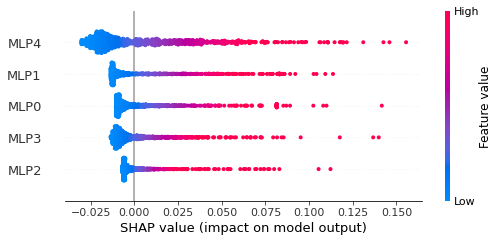

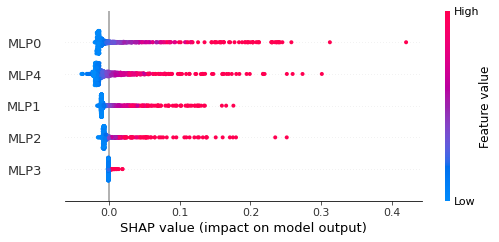

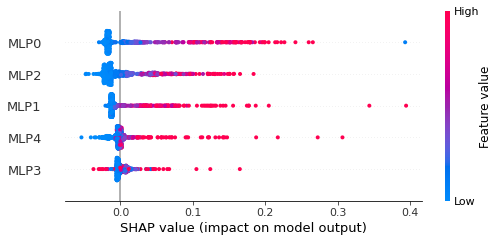

In [68]:
np.random.seed(24909)
expli_inds = np.random.choice(range(X_test_meta.shape[0]), 1000)
refer_inds = np.random.choice(range(X_valid_meta.shape[0]), 100)
expli_meta = X_test_meta[expli_inds]
refer_meta = X_valid_meta[refer_inds]
explicand  = X_test.iloc[expli_inds].values
reference  = X_valid.iloc[refer_inds].values

# Explain avg bagging model
avg_meta_attr = (1/expli_meta.shape[1])*(expli_meta - refer_meta.mean(0))
shap.summary_plot(avg_meta_attr, expli_meta, [f"MLP{i}" for i in range(5)])

# Explain logistic meta-model (convert to probability explanation)
lin_meta_attr_per_marg = (expli_meta[:,None,:] - refer_meta[None,:,:]) * lin_meta_model.coef_[None, :]

expli_prob = lin_meta_model.predict_proba(expli_meta)[:,1]
refer_prob = lin_meta_model.predict_proba(refer_meta)[:,1]
expli_marg = expli_meta @ lin_meta_model.coef_.T[:,0]
refer_marg = refer_meta @ lin_meta_model.coef_.T[:,0]
numer   = (expli_prob[:,None] - refer_prob[None,:])
denom   = (expli_marg[:,None] - refer_marg[None,:])
rescale = (numer/denom)

lin_meta_attr_per_prob = lin_meta_attr_per_marg*rescale[:,:,None]
lin_meta_attr_prob = lin_meta_attr_per_prob.mean(1)

shap.summary_plot(lin_meta_attr_prob, expli_meta, [f"MLP{i}" for i in range(5)])

# Explain tree meta-model
gbc_meta_expl = shap.TreeExplainer(gbc_meta_model, refer_meta, model_output="probability")
gbc_meta_attr = gbc_meta_expl.shap_values(expli_meta)
shap.summary_plot(gbc_meta_attr, expli_meta, [f"MLP{i}" for i in range(5)])

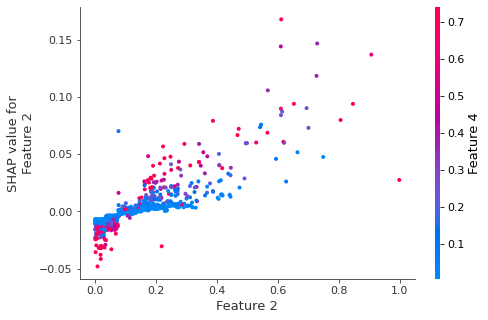

In [54]:
shap.dependence_plot(2,gbc_meta_attr, expli_meta)

### Attribution for average is the sum or all attributions times 1/5

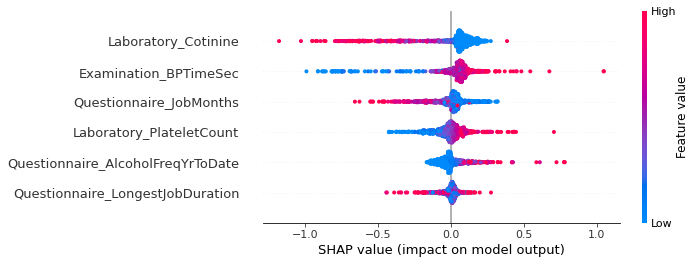

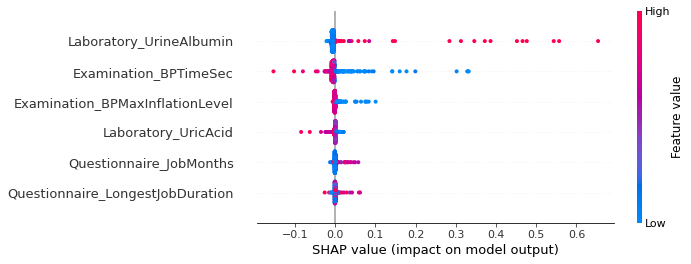

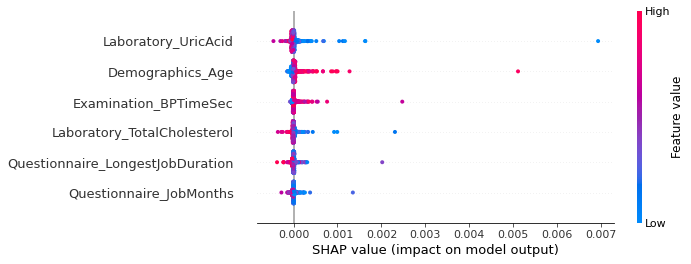

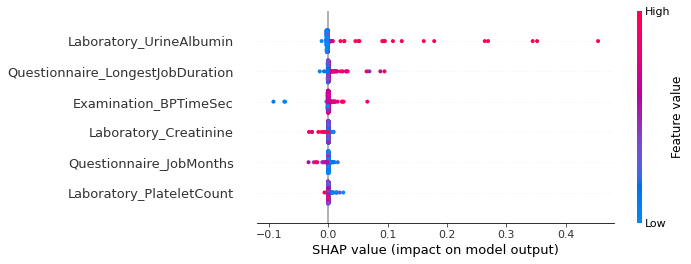

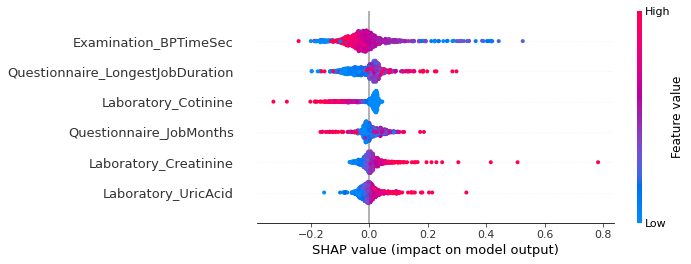

In [69]:
deep_attr_lst = []
for model in models:
    explainer = shap.DeepExplainer(model, reference)
    deep_attr = explainer.shap_values(explicand, per_reference=True)[0]
    deep_attr_lst.append(deep_attr)
    shap.summary_plot(deep_attr.mean(1), explicand, X_train.columns, max_display=6)

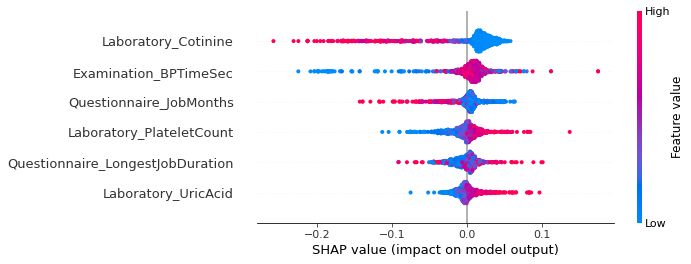

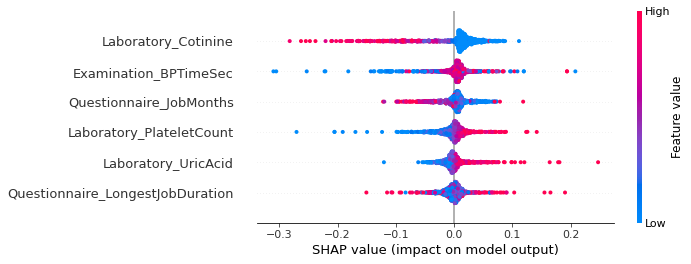

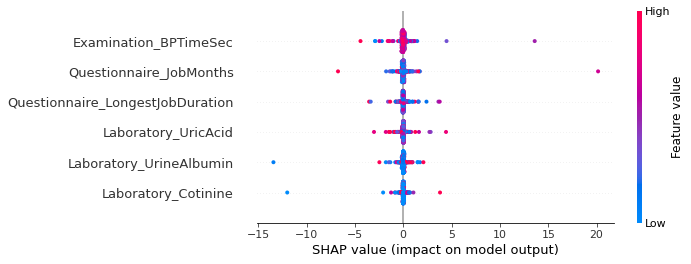

In [70]:
# Average ensemble
avg_meta_attr_x = np.array(deep_attr_lst).mean(2).mean(0) # Average across models and reference
shap.summary_plot(avg_meta_attr_x, explicand, X_train.columns, max_display=6)

# Linear meta model
expli_prob = lin_meta_model.predict_proba(expli_meta)[:,1]
refer_prob = lin_meta_model.predict_proba(refer_meta)[:,1]
expli_marg = expli_meta @ lin_meta_model.coef_.T[:,0]
refer_marg = refer_meta @ lin_meta_model.coef_.T[:,0]
numer   = (expli_prob[:,None] - refer_prob[None,:])
denom   = (expli_marg[:,None] - refer_marg[None,:])
rescale = (numer/denom)
beta = lin_meta_model.coef_[0,:]
lin_meta_attr_x = ((np.array(deep_attr_lst) * beta[:,None,None,None]).sum(0) * rescale[:,:,None]).mean(1)
shap.summary_plot(lin_meta_attr_x, explicand, X_train.columns, max_display=6)

# GBC meta model
safe_div = lambda a,b : np.divide(a, b, out=np.zeros_like(a), where=b!=0)
gbc_meta_attr_per = gbc_meta_expl.shap_values(expli_meta, per_reference=True)
gbc_meta_attr_per = np.swapaxes(gbc_meta_attr_per, 0, 1)
rescale = safe_div(gbc_meta_attr_per,np.array(deep_attr_lst).sum(3))
gbc_meta_attr_x = (np.array(deep_attr_lst) * rescale[:,:,:,None]).sum(0).mean(1)
shap.summary_plot(gbc_meta_attr_x, explicand, X_train.columns, max_display=6)

In [76]:
gbc_meta_attr_x.sum(1)

array([ 4.12878751e-01,  3.72175813e-02, -2.83677635e-02,  3.56682887e-01,
       -5.24493292e-02, -4.44253263e-02, -4.34109262e-02, -5.67508948e-02,
       -5.67394648e-02, -5.53717888e-02, -4.23260945e-02, -6.45204143e-02,
       -5.39793421e-02, -6.27354069e-02,  1.39711640e-01, -5.79130295e-02,
       -5.82473203e-02, -5.75329698e-02, -4.79445141e-02, -5.75329697e-02,
        2.42716547e-01, -5.97655847e-02, -6.45204142e-02,  4.85368703e-03,
        9.16198155e-02, -4.96543671e-02, -5.75135855e-02, -2.57840529e-02,
       -5.66988441e-02,  1.83128635e-02,  1.47763842e-02, -5.34489497e-02,
       -5.90572060e-02, -5.39793422e-02, -4.45975072e-02, -5.34489496e-02,
       -5.97655847e-02, -5.05189201e-02,  2.25769718e-02, -5.05189201e-02,
       -5.19303742e-02,  5.34381410e-01, -5.24493291e-02, -1.93975370e-02,
       -5.39793422e-02,  1.63899406e-01, -3.16707384e-02, -5.90855327e-02,
       -8.86494204e-03, -5.62637880e-02,  4.88241438e-02, -5.06703438e-02,
       -5.82697127e-02, -